In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets

import numpy as np
import seaborn as sns
import random

from PIL import Image, ImageChops

In [2]:
class RemoveBorder:
    def __call__(self, img):
        # Convert to RGB
        rgb = img.convert("RGB")

        # Use top-left pixel as assumed border color
        bg = Image.new("RGB", rgb.size, rgb.getpixel((0, 0)))

        # Difference image
        diff = ImageChops.difference(rgb, bg)
        bbox = diff.getbbox()

        # Crop if border detected
        if bbox:
            return rgb.crop(bbox)
        return rgb

In [3]:
img_size = (224, 224)
train_transform = transforms.Compose([
    RemoveBorder(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

dev_transform = transforms.Compose([
    RemoveBorder(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    RemoveBorder(),
    transforms.Resize(img_size),
    transforms.ToTensor()])

In [ ]:
img = Image.open("images_original/blues/blues00000.png")
RB = RemoveBorder()
img = RB(img)

print(img.size)
img = transforms.Resize((224, 224))
print(img.size)
print(img)

(336, 218)
(224, 224)
Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)


In [5]:
dataset = datasets.ImageFolder(root= "images_original")
dataset.classes
len(dataset)

999

In [ ]:

generator = t.Generator().manual_seed(42)
train_data, dev_data, test_data = random_split(
    dataset, [700, 150, 149], generator=generator
)

In [7]:
train_data.dataset.transform = train_transform
dev_data.dataset.transform = dev_transform
test_data.dataset.transform = test_transform

In [8]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle= True)
dev_loader = DataLoader(dev_data, batch_size = batch_size, shuffle= False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle= False)

In [ ]:
class VGG_net(nn.Module):
    def __init__(self):
        super(VGG_net, self).__init__()

        def block(input, output):
            return nn.Sequential(
                nn.Conv2d(input, output, 3, 1, 1),
                nn.ReLU(),
                nn.Conv2d(output, output, 3, 1, 1),
                nn.ReLU(),
                nn.BatchNorm2d(output),
                nn.MaxPool2d(2)
            )

        self.block1 = block(3, 32)
        self.block2 = block(32, 64)
        self.block3 = block(64, 128)
        self.block4 = block(128, 256)
        self.block5 = block(256, 256)

        self.fc = nn.Sequential(
            nn.Linear(256*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [10]:
model = VGG_net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = t.device("mps" if t.backends.mps.is_available() else "cpu")
model.to(device)
device

device(type='mps')

In [11]:
model.block4(t.rand([1, 128, 28, 28]).to(device)).shape

torch.Size([1, 256, 14, 14])

In [12]:
model.fc(t.rand([1, 256*14*14]).to(device)).shape

torch.Size([1, 10])

In [ ]:
epochs = 25
cost_hist = []

for i in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = t.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        cost_hist.append(total_loss / len(train_loader))
        train_acc = (correct_train / total_train) * 100

    with t.no_grad():
        model.eval()
        dev_loss = 0
        correct_dev, total_dev = 0, 0
        for images_d, labels_d in dev_loader:
            images_d, labels_d = images_d.to(device), labels_d.to(device)

            output_d = model(images_d)

            _, predicted_d = t.max(output_d, 1)
            total_dev += labels_d.size(0)
            correct_dev += (predicted_d == labels_d).sum().item()

            dev_acc = (correct_dev / total_dev) * 100

    print(f"Epochs: {i+1}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}%, Dev Acc: {dev_acc:.4f}%")



In [14]:
model.eval()
correct_test, total_test = 0, 0
with t.no_grad():
        for images_t, labels_t in test_loader:
            images_t, labels_t = images_t.to(device), labels_t.to(device)

            output_t = model(images_t)

            _, predicted_t = t.max(output_t, 1)
            total_test += labels_t.size(0)
            correct_test += (predicted_t == labels_t).sum().item()

            test_acc = (correct_test / total_test) * 100

print(test_acc)

51.006711409395976


<Axes: >

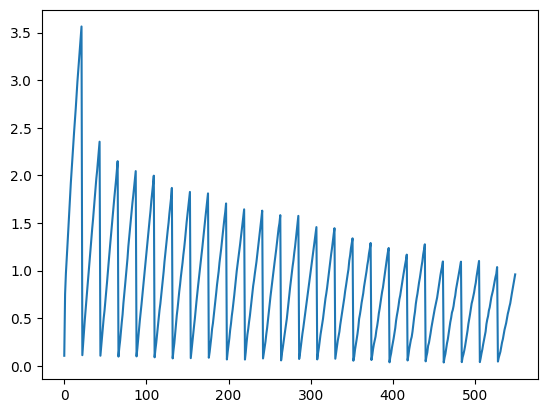

In [15]:
sns.lineplot(x= range(len(cost_hist)), y= cost_hist)